In [3]:
#!/usr/bin/python

import numpy as np
import math
from astropy.io import fits as fits
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import pandas as pd
from pandas import DataFrame, Series
from astropy.wcs import WCS as WCS

import import_ipynb

from mpdaf.obj import hms2deg
from mpdaf.obj import dms2deg

from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve

import matplotlib.gridspec as gridspec

In [4]:
name = 'SN2006et'

In [5]:
df = pd.read_csv('Amusing_Table_true.csv')  # To find the Galaxy data
Names_1 = df['SN_name']
Names_2 = df['def_name']
R = 0

for names in Names_1:              # Finding the Galaxy in the DataFrame
    R=R+1
    if name == names:
        Row = R-1
R = 0
for names in Names_2:              # Some Galaxies have the name in other column
    R=R+1
    if name == names:
        Row = R-1

# Pixel de la SN
Pix_X = df.at[Row,'SNX'] -1
Pix_Y = df.at[Row,'SNY'] -1
# Pixel del centro de la Galaxia
Pix_X_GAL = df.at[Row,'GALX'] -1
Pix_Y_GAL = df.at[Row,'GALY'] -1

# Supernova type
if df.at[Row,'SN_type'] == 'Ia':
    SN_TYPE = 1
elif df.at[Row,'SN_type'] == 'II':
    SN_TYPE = 2
else:
    SN_TYPE = 0

In [6]:
    # SN coordinates
    RA_SN = df.at[Row,'RA_SN']
    RA_SN = hms2deg(RA_SN)
    
    DEC_SN = df.at[Row,'DEC_SN']
    DEC_SN = dms2deg(DEC_SN)
    
    # Galaxy center coordinates
    RA_GAL = df.at[Row,'RA_GAL']
    RA_GAL = hms2deg(RA_GAL)
    
    DEC_GAL = df.at[Row,'DEC_GAL']
    DEC_GAL = dms2deg(DEC_GAL)
    
    # Pixel position
    w = WCS('../Data/Amusing/flux_elines.'+name+'.cube.fits')
    Pix_X, Pix_Y ,z = w.wcs_world2pix(RA_SN, DEC_SN, 0. , 0,ra_dec_order=True)
    Pix_X_GAL, Pix_Y_GAL ,z = w.wcs_world2pix(RA_GAL, DEC_GAL, 0. , 0,ra_dec_order=True)
    
    # Integer for measure
    Pix_X = int(Pix_X)
    Pix_Y = int(Pix_Y)

a floating-point value was expected. [astropy.wcs.wcs]


In [7]:
import Pipe3D_Asier_Test_IA as Pipe3D
# Call to Pipe3D code
line = Pipe3D.Pipe3D_galaxy(name)

# Read the Ha map of the galaxy
hdulist = fits.open('../Data/Amusing/flux_elines.'+line.name+'.cube.fits')
line.Ha_Map = hdulist[0].data[20]

Ha_Map = line.Ha_Map

importing Jupyter notebook from Pipe3D_Asier_Test_IA.ipynb


In [8]:
import Pipe3D_Asier_Test_Mass as Pipe3D

# Call to Pipe3D code
line = Pipe3D.Pipe3D_galaxy(name)

# Obtain the maps for the galaxy
line.painting_galaxy_maps(False, 1.2, 150, 30)

SN_Mass_rate_map = line.SN_Mass_rate_map

importing Jupyter notebook from Pipe3D_Asier_Test_Mass.ipynb


In [7]:
import Pipe3D_Asier_Test_IA as Pipe3D

# Call to Pipe3D code
line = Pipe3D.Pipe3D_galaxy(name)

# Obtain the maps for the galaxy
line.painting_galaxy_maps(False, 1.2, 150, 30)

SNIa_rate_map = line.SNIa_rate_map

importing Jupyter notebook from Pipe3D_Asier_Test_IA.ipynb


In [8]:
import Pipe3D_Asier_Test_II as Pipe3D

# Call to Pipe3D code
line = Pipe3D.Pipe3D_galaxy(name)

# Obtain the maps for the galaxy
line.painting_galaxy_maps(False, 1.2, 150, 30)

SNII_rate_map = line.SNII_rate_map

importing Jupyter notebook from Pipe3D_Asier_Test_II.ipynb


In [9]:
# Gaussian function
stddev = 7
gauss = Gaussian2DKernel(stddev)

# Gaussian convolve
Ha_Map = convolve(Ha_Map, gauss)
SN_Mass_rate_map = convolve(SN_Mass_rate_map, gauss)
SNIa_rate_map = convolve(SNIa_rate_map, gauss)
SNII_rate_map = convolve(SNII_rate_map, gauss)

# Eliminate negative values
SN_Mass_rate_map[SN_Mass_rate_map<0.0] = 0.0
SNIa_rate_map[SNIa_rate_map<0.0] = 0.0
SNII_rate_map[SNII_rate_map<0.0] = 0.0

# An Array whit all the value of the Ha map
Prob_List = np.ndarray.flatten(Ha_Map)
Prob_List_Mass = np.ndarray.flatten(SN_Mass_rate_map)
Prob_List_Ia = np.ndarray.flatten(SNIa_rate_map)
Prob_List_II = np.ndarray.flatten(SNII_rate_map)

# The array orther in value
Order_Prob_List = np.sort(Prob_List)
Order_Prob_List_Mass = np.sort(Prob_List_Mass)
Order_Prob_List_Ia = np.sort(Prob_List_Ia)
Order_Prob_List_II = np.sort(Prob_List_II)

# Standard deviation of negative values (indicatve of noise level)
Sigmas_of_noise = 6

noise_level = Sigmas_of_noise * np.nanstd(Prob_List[Prob_List<0])
Order_Prob_List[Order_Prob_List<noise_level] = 0.
Ha_Map[Ha_Map<noise_level] = 0.

# Normalizar
Norm_Ha = 0
for i in range(len(Order_Prob_List)):
    Norm_Ha = Norm_Ha + Order_Prob_List[i]
Order_Prob_List = Order_Prob_List / Norm_Ha
Ha_Map = Ha_Map / Norm_Ha

Norm_SN_Mass = 0
for i in range(len(Order_Prob_List_Mass)):
    Norm_SN_Mass = Norm_SN_Mass + Order_Prob_List_Mass[i]
Order_Prob_List_Mass = Order_Prob_List_Mass / Norm_SN_Mass
SN_Mass_rate_map = SN_Mass_rate_map / Norm_SN_Mass

Norm_SNIa = 0
for i in range(len(Order_Prob_List_Ia)):
    Norm_SNIa = Norm_SNIa + Order_Prob_List_Ia[i]
Order_Prob_List_Ia = Order_Prob_List_Ia / Norm_SNIa
SNIa_rate_map = SNIa_rate_map / Norm_SNIa

Norm_SNII = 0
for i in range(len(Order_Prob_List_II)):
    Norm_SNII = Norm_SNII + Order_Prob_List_II[i]
Order_Prob_List_II = Order_Prob_List_II / Norm_SNII
SNII_rate_map = SNII_rate_map / Norm_SNII

# Calculate P
cumulative_P_values = np.cumsum(Order_Prob_List)
cumulative_P_values_Mass = np.cumsum(Order_Prob_List_Mass)
cumulative_P_values_Ia = np.cumsum(Order_Prob_List_Ia)
cumulative_P_values_II = np.cumsum(Order_Prob_List_II)

# Calculate P map
cumulative_Ha_Map = np.interp(Ha_Map, Order_Prob_List, cumulative_P_values)
cumulative_SN_Mass_rate_map = np.interp(SN_Mass_rate_map, Order_Prob_List_Mass, cumulative_P_values_Mass)
cumulative_SNIa_rate_map = np.interp(SNIa_rate_map, Order_Prob_List_Ia, cumulative_P_values_Ia)
cumulative_SNII_rate_map = np.interp(SNII_rate_map, Order_Prob_List_II, cumulative_P_values_II)

/home/asier/anaconda2/lib/python2.7/site-packages/astropy/convolution/convolve.py:108: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .boundary_none import (convolve1d_boundary_none,
/home/asier/anaconda2/lib/python2.7/site-packages/astropy/convolution/convolve.py:112: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .boundary_extend import (convolve1d_boundary_extend,
/home/asier/anaconda2/lib/python2.7/site-packages/astropy/convolution/convolve.py:116: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .boundary_fill import (convolve1d_boundary_fill,
/home/asier/anaconda2/lib/python2.7/site-packages/astropy/convolution/convolve.py:120: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .boundary_wrap import (convolve1d_boundary_wrap,


NameError: name 'SNIa_rate_map' is not defined

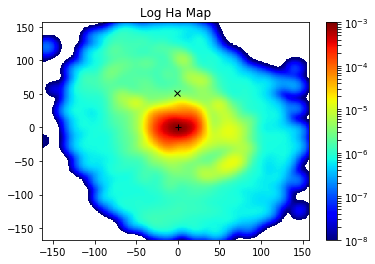

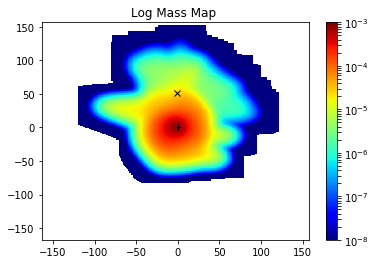

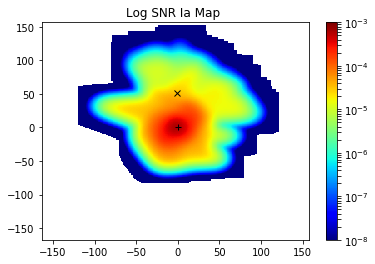

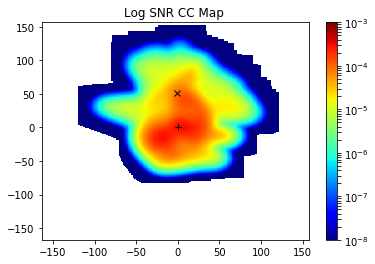

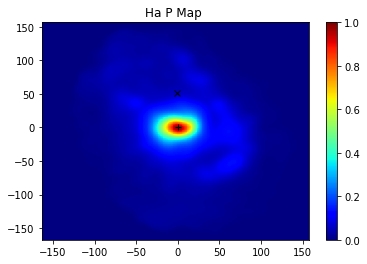

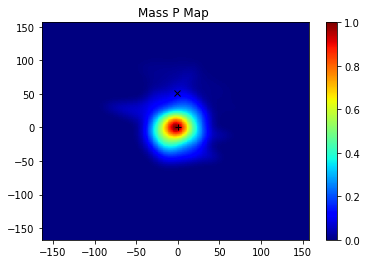

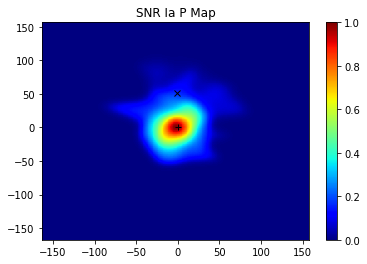

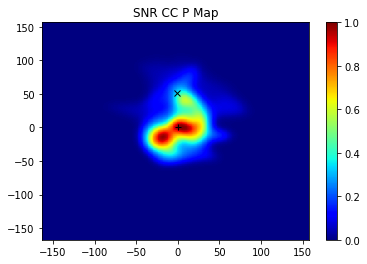

In [55]:
x = np.arange(len(Ha_Map[0,:]))-[Pix_X_GAL]
y = np.arange(len(Ha_Map[:,0]))-[Pix_Y_GAL]
plt.pcolor(x,y,Ha_Map, norm=LogNorm(),vmin=0.00000001, vmax=0.001, cmap='jet')
plt.plot(0,0,'k+')
plt.plot([Pix_X-Pix_X_GAL],[Pix_Y-Pix_Y_GAL],'kx')
plt.title( 'Log Ha Map')
plt.colorbar()
#plt.savefig('../SN2006et_Ha_Map_Log.png')
plt.show()


x = np.arange(len(SN_Mass_rate_map[0,:]))-[Pix_X_GAL]
y = np.arange(len(SN_Mass_rate_map[:,0]))-[Pix_Y_GAL]
plt.pcolor(x,y,SN_Mass_rate_map, norm=LogNorm(),vmin=0.00000001, vmax=0.001, cmap='jet')
plt.plot(0,0,'k+')
plt.plot([Pix_X-Pix_X_GAL],[Pix_Y-Pix_Y_GAL],'kx')
plt.title( 'Log Mass Map ')
plt.colorbar()
#plt.savefig('../SN2006et_Mass_Map_Log.png')
plt.show()

x = np.arange(len(SNIa_rate_map[0,:]))-[Pix_X_GAL]
y = np.arange(len(SNIa_rate_map[:,0]))-[Pix_Y_GAL]
plt.pcolor(x,y,SNIa_rate_map, norm=LogNorm(),vmin=0.00000001, vmax=0.001, cmap='jet')
plt.plot(0,0,'k+')
plt.plot([Pix_X-Pix_X_GAL],[Pix_Y-Pix_Y_GAL],'kx')
plt.title( 'Log SNR Ia Map ')
plt.colorbar()
#plt.savefig('../SN2006et_Ia_Map_Log.png')
plt.show()

x = np.arange(len(SNII_rate_map[0,:]))-[Pix_X_GAL]
y = np.arange(len(SNII_rate_map[:,0]))-[Pix_Y_GAL]
plt.pcolor(x,y,SNII_rate_map, norm=LogNorm(),vmin=0.00000001, vmax=0.001, cmap='jet')
plt.plot(0,0,'k+')
plt.plot([Pix_X-Pix_X_GAL],[Pix_Y-Pix_Y_GAL],'kx')
plt.title( 'Log SNR CC Map ')
plt.colorbar()
#plt.savefig('../SN2006et_II_Map_Log.png')
plt.show()

x = np.arange(len(cumulative_Ha_Map[0,:]))-[Pix_X_GAL]
y = np.arange(len(cumulative_Ha_Map[:,0]))-[Pix_Y_GAL]
plt.pcolor(x,y,cumulative_Ha_Map, cmap='jet')
plt.plot(0,0,'k+')
plt.plot([Pix_X-Pix_X_GAL],[Pix_Y-Pix_Y_GAL],'kx')
plt.title( 'Ha P Map ')
plt.colorbar()
#plt.savefig('../SN2006et_Ha_P_Map_Log.png')
plt.show()

x = np.arange(len(cumulative_SN_Mass_rate_map[0,:]))-[Pix_X_GAL]
y = np.arange(len(cumulative_SN_Mass_rate_map[:,0]))-[Pix_Y_GAL]
plt.pcolor(x,y,cumulative_SN_Mass_rate_map, cmap='jet')
plt.plot(0,0,'k+')
plt.plot([Pix_X-Pix_X_GAL],[Pix_Y-Pix_Y_GAL],'kx')
plt.title( 'Mass P Map ')
plt.colorbar()
#plt.savefig('../SN2006et_Mass_P_Map_Log.png')
plt.show()

x = np.arange(len(cumulative_SNIa_rate_map[0,:]))-[Pix_X_GAL]
y = np.arange(len(cumulative_SNIa_rate_map[:,0]))-[Pix_Y_GAL]
plt.pcolor(x,y,cumulative_SNIa_rate_map, cmap='jet')
plt.plot(0,0,'k+')
plt.plot([Pix_X-Pix_X_GAL],[Pix_Y-Pix_Y_GAL],'kx')
plt.title( 'SNR Ia P Map')
plt.colorbar()
#plt.savefig('../SN2006et_Ia_P_Map_Log.png')
plt.show()

x = np.arange(len(cumulative_SNII_rate_map[0,:]))-[Pix_X_GAL]
y = np.arange(len(cumulative_SNII_rate_map[:,0]))-[Pix_Y_GAL]
plt.pcolor(x,y,cumulative_SNII_rate_map, cmap='jet')
plt.plot(0,0,'k+')
plt.plot([Pix_X-Pix_X_GAL],[Pix_Y-Pix_Y_GAL],'kx')
plt.title( 'SNR CC P Map')
plt.colorbar()
#plt.savefig('../SN2006et_II_P_Map_Log.png')
plt.show()
